In [1]:
import pandas as pd
import os

In [2]:
import cv2
from google.colab.patches import cv2_imshow

**Converting annotations from txt format to json**

In [6]:

def createjson(path,file_list):
  header = ["x1", "x2", "x3", "x4","y1", "y2","y3", "y4", "category_id"]
  df_json=pd.DataFrame(columns=["file_name","height","width","annotations"])
  counter=pd.DataFrame(columns=["file_name","height","width","annotations"])
  df_json["annotations"]=df_json["annotations"].astype('object')
  for i in file_list:
    # print(i)
    df = pd.read_csv("/content/drive/MyDrive/text-detection/Text_Detection/"+path+"/Annotations/"+i,header = None,index_col=False,names=header)
    df["height"] = abs(df["y1"]-df["y3"])
    df["width"] = abs(df["x1"]-df["x3"])
    df=df[["x1","y1","width","height","category_id"]]
    if (len(list(df['category_id'].value_counts().index))==1) & (list(df['category_id'].value_counts().index)[0]=='HINDI'):
      continue
    counter['file_name']=i
    counter=counter.append(df)
    df['category_id']=df['category_id'].map({"HINDI":"0","ENGLISH":"1","OTHER":"2"})
    df=df[df['category_id'].isin(["0","1","2"])]
    df['bbox_mode']=1
    df['bbox']=df[["x1","y1","width","height"]].values.tolist()
    df.drop(columns=["x1","y1","width","height"],inplace=True,axis=1)
    annotations=df.to_dict(orient='records')
    img_dim = cv2.imread("/content/drive/MyDrive/text-detection/Text_Detection/"+path+"/Images/"+str(i[:-4])+".jpeg").shape[:2]
    data_df=pd.DataFrame(columns=["file_name","height","width","annotations"])
    data_df["annotations"]=data_df["annotations"].astype('object')
    data_df.loc[0,"annotations"] = annotations
    data_df["height"] = img_dim[0]
    data_df["width"] = img_dim[1]
    data_df.loc[:,'file_name'] = "/content/drive/MyDrive/text-detection/Text_Detection/"+path+"/Images/"+str(i[:-4])+".jpeg"
    df_json=df_json.append(data_df)
  return df_json,counter

In [8]:
print('Training JSON')
train_file_list =  os.listdir('/content/drive/MyDrive/text-detection/Text_Detection/Train/Annotations')
train_anno_df,op=createjson("Train",train_file_list)
train_anno_df.reset_index(inplace=True)
train_anno_df.rename(columns={"index":"image_id"},inplace=True)
train_anno_df.to_json("train.json",orient="records")

print('Validation JSON')
val_file_list =  os.listdir('/content/drive/MyDrive/text-detection/Text_Detection/Val/Annotations')
val_anno_df,_=createjson("Val",val_file_list)
val_anno_df.reset_index(inplace=True)
val_anno_df.rename(columns={"index":"image_id"},inplace=True)
val_anno_df.to_json("valid.json",orient="records")

Training JSON
Validation JSON


In [9]:
train_anno_df.head()

,image_id,file_name,height,width,annotations
0,0,/content/drive/MyDrive/text-detection/Text_Det...,500,715,"[{'category_id': '0', 'bbox_mode': 1, 'bbox': ..."
1,0,/content/drive/MyDrive/text-detection/Text_Det...,500,715,"[{'category_id': '0', 'bbox_mode': 1, 'bbox': ..."
2,0,/content/drive/MyDrive/text-detection/Text_Det...,500,715,"[{'category_id': '0', 'bbox_mode': 1, 'bbox': ..."
3,0,/content/drive/MyDrive/text-detection/Text_Det...,500,715,"[{'category_id': '2', 'bbox_mode': 1, 'bbox': ..."
4,0,/content/drive/MyDrive/text-detection/Text_Det...,430,715,"[{'category_id': '0', 'bbox_mode': 1, 'bbox': ..."


**Installing the required dependencies**

In [10]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

     |████████████████████████████████| 276kB 9.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=d4b72fe97975b11b3fddd21a27bd3e5ebaf9b01103dee69972f040eb881debbb
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [11]:
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 4.3MB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201210-cp36-none-any.whl size=44711 sha256=3c5b721abd9a996a92bca8a82b946cd8e119a3549a4f1286018b9926b34f185b
  Stored in directory: /root/.cache/pip/wheels/ab/ce/d3/0b7bccf09516b236307289c3a9ad80fcf37431eca5f6624486
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
# DatasetCatalog.remove("/content/train.json")
# DatasetCatalog.remove("/content/valid.json")

In [5]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    json_file = imgdir#+"/dataset.json" #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts: 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            # print(j['category_id'])
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
#Registering the Dataset
for d in ["/content/train.json", "/content/valid.json"]:
    DatasetCatalog.register(d, lambda d=d: get_board_dicts(d))
    MetadataCatalog.get(d).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("/content/train.json")

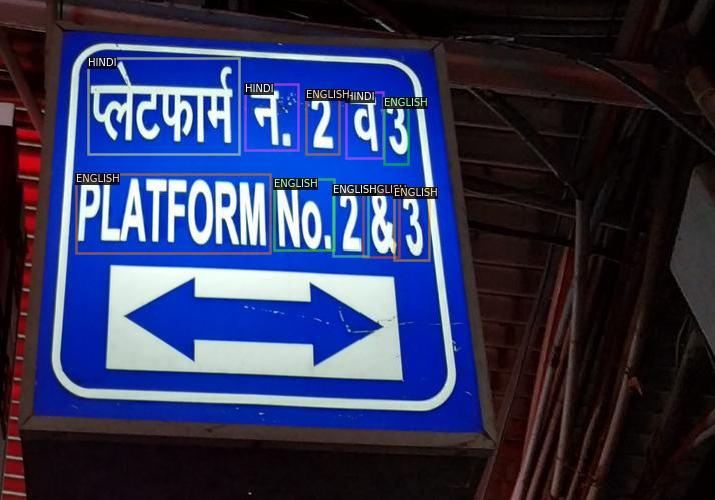

In [6]:
#Visualizing the Train Dataset
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_board_dicts("/content/train.json")
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 1):
    # print(d["file_name"])
    img = cv2.imread(d["file_name"])
    # print(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    # annos = d.get("annotations", None) 
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("/content/train.json",)
cfg.DATASETS.TEST = ("/content/valid.json",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# Number of images per batch across all machines. faster_rcnn_R_101_FPN_3x
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00045 
cfg.SOLVER.MAX_ITER = 3000  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.TEST.EVAL_PERIOD = 800 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# cfg.DATASETS.TEST = ("boardetect_val", )


In [10]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/10 01:07:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 57.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.


[12/10 01:08:02 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[12/10 01:08:20 d2.utils.events]:  eta: 0:43:05  iter: 19  total_loss: 3.218  loss_cls: 1.224  loss_box_reg: 0.4295  loss_rpn_cls: 1.288  loss_rpn_loc: 0.1357  time: 0.8688  data_time: 0.0375  lr: 8.9914e-06  max_mem: 4957M
[12/10 01:08:38 d2.utils.events]:  eta: 0:44:16  iter: 39  total_loss: 2.539  loss_cls: 1.105  loss_box_reg: 0.5186  loss_rpn_cls: 0.7042  loss_rpn_loc: 0.124  time: 0.8991  data_time: 0.0182  lr: 1.7982e-05  max_mem: 4957M
[12/10 01:08:57 d2.utils.events]:  eta: 0:44:02  iter: 59  total_loss: 2.138  loss_cls: 0.9709  loss_box_reg: 0.7578  loss_rpn_cls: 0.3006  loss_rpn_loc: 0.112  time: 0.9038  data_time: 0.0130  lr: 2.6973e-05  max_mem: 4957M
[12/10 01:09:15 d2.utils.events]:  eta: 0:44:15  iter: 79  total_loss: 1.91  loss_cls: 0.8128  loss_box_reg: 0.8096  loss_rpn_cls: 0.08844  loss_rpn_loc: 0.1273  time: 0.9090  data_time: 0.0156  lr: 3.5964e-05  max_mem: 4957M
[12/10 01:09:33 d2.utils.events]:  eta: 0:43:50  iter: 99  total_loss: 1.812  loss_cls: 0.7431  loss_

In [12]:
!cp "/content/output/model_final.pth" "/content/drive/MyDrive/text-detection/models"

In [2]:
# from detectron2.utils.visualizer import ColorMode

# #Use the final weights generated after successful training for inference  
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
# #Pass the validation dataset
# cfg.DATASETS.TEST = ("boardetect_val", )

# predictor = DefaultPredictor(cfg)

# dataset_dicts = get_board_dicts("/content/valid.json")
# for d in random.sample(dataset_dicts, 1):    
#     im = cv2.imread('/content/d2.jpg')
#     outputs = predictor(im)
#     print(outputs)
#     v = Visualizer(im[:, :, ::-1],
#                    metadata=board_metadata, 
#                    scale=0.8,
#                    instance_mode=ColorMode.IMAGE   
#     )
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
#     cv2_imshow(v.get_image()[:, :, ::-1])

In [1]:
# #import the COCO Evaluator to use the COCO Metrics
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader

# #Call the COCO Evaluator function and pass the Validation Dataset
# evaluator = COCOEvaluator("/content/valid.json", cfg, False, output_dir="/output/")
# val_loader = build_detection_test_loader(cfg, "/content/valid.json")

# #Use the created predicted model in the previous step
# inference_on_dataset(predictor.model, val_loader, evaluator)